Code for BERT Pipeline

2025-03-14 17:00:13.823989: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-14 17:00:13.824025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-14 17:00:13.825134: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-14 17:00:13.831126: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-14 17:00:14.476563: W tensorflow/compiler/tf2

Epoch [1/20] - Train Loss: 1.0727, Train Acc: 0.5659, Val Loss: 0.9304, Val Acc: 0.6604
Epoch [2/20] - Train Loss: 0.7681, Train Acc: 0.7189, Val Loss: 0.8160, Val Acc: 0.6685
Epoch [3/20] - Train Loss: 0.6520, Train Acc: 0.7510, Val Loss: 0.7653, Val Acc: 0.7089
Epoch [4/20] - Train Loss: 0.5630, Train Acc: 0.7876, Val Loss: 0.7734, Val Acc: 0.6873
Epoch [5/20] - Train Loss: 0.4969, Train Acc: 0.8204, Val Loss: 0.7660, Val Acc: 0.7089
Epoch [6/20] - Train Loss: 0.4384, Train Acc: 0.8354, Val Loss: 0.7616, Val Acc: 0.6954
Epoch [7/20] - Train Loss: 0.3839, Train Acc: 0.8552, Val Loss: 0.7703, Val Acc: 0.7278
Epoch [8/20] - Train Loss: 0.3281, Train Acc: 0.8788, Val Loss: 0.7415, Val Acc: 0.7655
Epoch [9/20] - Train Loss: 0.2766, Train Acc: 0.8979, Val Loss: 0.7756, Val Acc: 0.7466
Epoch [10/20] - Train Loss: 0.2333, Train Acc: 0.9208, Val Loss: 0.7923, Val Acc: 0.7601
Epoch [11/20] - Train Loss: 0.1910, Train Acc: 0.9351, Val Loss: 0.8636, Val Acc: 0.7358
Epoch [12/20] - Train Loss: 0.

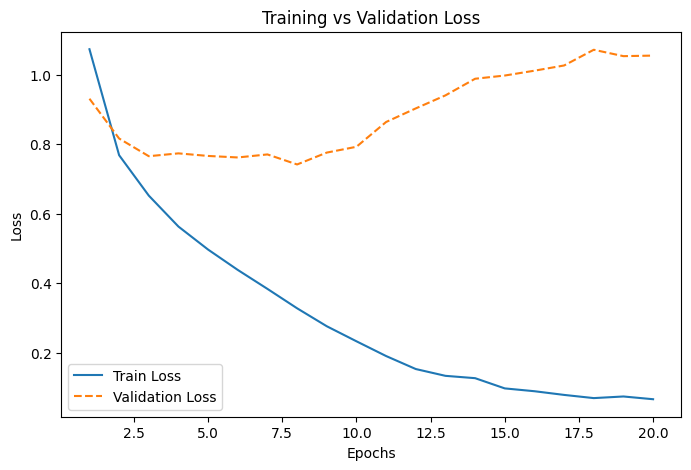

In [1]:
import json
import torch
import numpy as np
import random
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set seed for reproducbility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Load data from json file
def load_data(json_file):
    with open(json_file, "r", encoding="utf-8") as f:
        data = json.load(f)

    label_mapping = {"positive": 0, "negative": 1, "neutral": 2, "conflict": 3}
    texts, aspects, labels = [], [], []
    for entry in data:
        text = " ".join(entry["tokens"])
        aspect = entry["aspect_terms"][0] if entry["aspect_terms"] else "[UNK]"
        label = label_mapping[entry["polarity"]]
        texts.append(text)
        aspects.append(aspect)
        labels.append(label)

    return texts, aspects, labels

train_texts, train_aspects, train_labels = load_data("train_task_2.json")
val_texts, val_aspects, val_labels = load_data("val_task_2.json")

# Tokenize data using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def encode_data(texts, aspects, labels, max_length=128):
    input_encodings = tokenizer(
        [f"[CLS] {aspect} [SEP] {text} [SEP]" for text, aspect in zip(texts, aspects)],
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    )
    labels = torch.tensor(labels)
    return input_encodings, labels

train_encodings, train_labels = encode_data(train_texts, train_aspects, train_labels)
val_encodings, val_labels = encode_data(val_texts, val_aspects, val_labels)

# Create custom dataset class
class ABSADataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]

train_dataset = ABSADataset(train_encodings, train_labels)
val_dataset = ABSADataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load BERT model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
model.to(device)

# Set up optimizer, scheduler, and loss function
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 20)
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in train_loader:
        inputs, labels = batch
        inputs = {key: val.to(device) for key, val in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(**inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs = {key: val.to(device) for key, val in inputs.items()}
            labels = labels.to(device)

            outputs = model(**inputs).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

# Plot loss curves
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()



Save the Model

In [5]:
# Save the fine-tuned model
torch.save(model.state_dict(), "Model/Model_BERT.pth")
print("Model saved!")

Model saved!


BART

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/mnt/hdd/slimsense/myenv/lib/python3.9/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch [1/20] - Train Loss: 0.9548, Val Loss: 0.7863, Val Accuracy: 67.65%
Epoch [2/20] - Train Loss: 0.7021, Val Loss: 0.6985, Val Accuracy: 72.78%
Epoch [3/20] - Train Loss: 0.6077, Val Loss: 0.6486, Val Accuracy: 73.32%
Epoch [4/20] - Train Loss: 0.5090, Val Loss: 0.6524, Val Accuracy: 76.01%
Epoch [5/20] - Train Loss: 0.4048, Val Loss: 0.6010, Val Accuracy: 76.82%
Epoch [6/20] - Train Loss: 0.3088, Val Loss: 0.6910, Val Accuracy: 79.78%
Epoch [7/20] - Train Loss: 0.2505, Val Loss: 0.7307, Val Accuracy: 78.98%
Epoch [8/20] - Train Loss: 0.2034, Val Loss: 0.7161, Val Accuracy: 77.09%
Epoch [9/20] - Train Loss: 0.1572, Val Loss: 0.7208, Val Accuracy: 77.90%
Epoch [10/20] - Train Loss: 0.1270, Val Loss: 0.8513, Val Accuracy: 78.71%
Epoch [11/20] - Train Loss: 0.0910, Val Loss: 0.8559, Val Accuracy: 79.25%
Epoch [12/20] - Train Loss: 0.0660, Val Loss: 0.9468, Val Accuracy: 79.51%
Epoch [13/20] - Train Loss: 0.0566, Val Loss: 0.9558, Val Accuracy: 78.98%
Epoch [14/20] - Train Loss: 0.0654

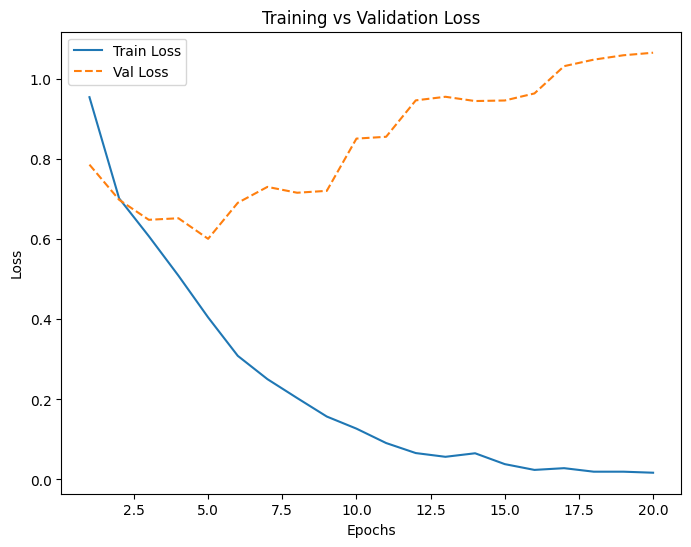

In [2]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import BartTokenizer, BartForSequenceClassification, AdamW, get_scheduler

# Set seed for reproducbility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Load data from json file
def load_data(json_file):
    with open(json_file, "r", encoding="utf-8") as f:
        data = json.load(f)

    label_mapping = {"positive": 0, "negative": 1, "neutral": 2, "conflict": 3}
    sentences, aspects, labels = [], [], []

    for entry in data:
        sentences.append(" ".join(entry["tokens"]))
        aspects.append(entry["aspect_terms"][0] if entry["aspect_terms"] else "[UNK]")
        labels.append(label_mapping[entry["polarity"]])

    return sentences, aspects, labels

# Load train and val data
train_sentences, train_aspects, train_labels = load_data("train_task_2.json")
val_sentences, val_aspects, val_labels = load_data("val_task_2.json")

# Load BART tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")

# Tokenize data
def tokenize_data(sentences, aspects, labels):
    inputs = tokenizer(
        sentences, aspects, padding=True, truncation=True, max_length=128, return_tensors="pt"
    )
    return inputs["input_ids"], inputs["attention_mask"], torch.tensor(labels)

train_inputs, train_masks, train_labels = tokenize_data(train_sentences, train_aspects, train_labels)
val_inputs, val_masks, val_labels = tokenize_data(val_sentences, val_aspects, val_labels)

# Create custom dataset class
class ABSADataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "labels": self.labels[idx],
        }

# Create datasets and dataloaders
train_dataset = ABSADataset(train_inputs, train_masks, train_labels)
val_dataset = ABSADataset(val_inputs, val_masks, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load BART model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BartForSequenceClassification.from_pretrained("facebook/bart-large", num_labels=4)
model.to(device)

# Set up optimizer, scheduler, and loss function
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-5)
num_epochs = 20  # Increased epochs for stability
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs)
loss_fn = torch.nn.CrossEntropyLoss()

# Function to evaluate model
def evaluate(model, val_loader):
    model.eval()
    correct, total, val_loss = 0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attn_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attn_mask)
            loss = loss_fn(outputs.logits, labels)
            val_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    return correct / total, val_loss / len(val_loader)

# Training loop
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attn_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attn_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()

    # Evaluate model
    val_acc, val_loss = evaluate(model, val_loader)

    # Save losses & accuracy
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_acc*100:.2f}%")

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()



Save the Model

In [6]:
# Save the fine-tuned model
torch.save(model.state_dict(), "Model/Model_BART.pth")
print("Model saved!")

Model saved!


ROBERTa Code

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/20] - Train Loss: 0.8571, Train Acc: 0.6605, Val Loss: 0.7981, Val Acc: 0.6981
Epoch [2/20] - Train Loss: 0.6033, Train Acc: 0.7654, Val Loss: 0.7553, Val Acc: 0.7251
Epoch [3/20] - Train Loss: 0.5038, Train Acc: 0.8046, Val Loss: 0.7226, Val Acc: 0.7116
Epoch [4/20] - Train Loss: 0.4439, Train Acc: 0.8214, Val Loss: 0.7858, Val Acc: 0.7035
Epoch [5/20] - Train Loss: 0.3854, Train Acc: 0.8426, Val Loss: 0.7443, Val Acc: 0.6819
Epoch [6/20] - Train Loss: 0.3550, Train Acc: 0.8484, Val Loss: 0.7686, Val Acc: 0.6846
Epoch [7/20] - Train Loss: 0.3179, Train Acc: 0.8511, Val Loss: 0.7596, Val Acc: 0.7116
Epoch [8/20] - Train Loss: 0.2928, Train Acc: 0.8589, Val Loss: 1.0169, Val Acc: 0.7197
Epoch [9/20] - Train Loss: 0.2947, Train Acc: 0.8535, Val Loss: 0.9108, Val Acc: 0.7143
Epoch [10/20] - Train Loss: 0.2792, Train Acc: 0.8603, Val Loss: 0.8356, Val Acc: 0.7089
Epoch [11/20] - Train Loss: 0.2588, Train Acc: 0.8589, Val Loss: 0.9357, Val Acc: 0.7278
Epoch [12/20] - Train Loss: 0.

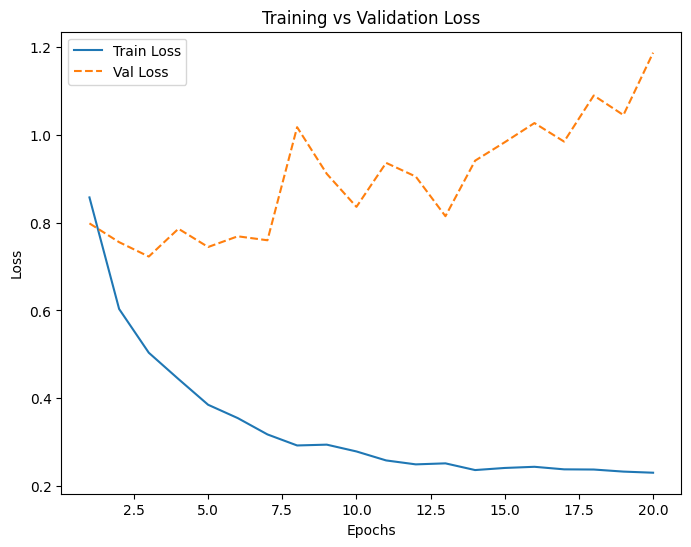

In [4]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW

# Set seed for reproducbility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Load data from json file
def load_data(json_file):
    with open(json_file, "r", encoding="utf-8") as f:
        return json.load(f)

train_data = load_data("train_task_2.json")
val_data = load_data("val_task_2.json")

# Sentiment label mapping
label_mapping = {"positive": 0, "negative": 1, "neutral": 2, "conflict": 3}

# Custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        text = " ".join(entry["tokens"])  # Convert tokens to sentence
        label = label_mapping[entry["polarity"]]

        inputs = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Create datasets
train_dataset = SentimentDataset(train_data, tokenizer)
val_dataset = SentimentDataset(val_data, tokenizer)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load RoBERTa model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)
model.to(device)

# Set up optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 20  # Increased epochs for better tuning
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Val Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()



Save The Model

In [7]:
# Save the fine-tuned model
torch.save(model.state_dict(), "Model/Model_ROBERTa.pth")
print("Model saved!")

Model saved!
